In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

# Datasets


We are currently using five different datasets
1. FDA Drug Approvals
2. FDA Adverse Events Data
3. Drug Utilization Data
4. FDA Clinical Trail Data
5. FDA Open Payments

## FDA Drug Approvals
### Dataset Description
FDA Drug Approval Dataset contains information about the products approved by FDA for human use. This dataset contains the unique NDA (National Drug Application) number, the name of the drug and the manufacturing company along with the date when the drug was approved by the FDA. This dataset also contains the active ingredients used to manufacture the drug.

### Data source
FDA Drug Approval Dataset is a publicly available which we can download from https://www.accessdata.fda.gov/scripts/cder/daf/

### Data Description
Important columns in this dataset are
1. Approval Date - The date when the drug was approved
2. Drug Name - The name of the drug
3. Active Ingredients - The active ingredients used to manufacture the drug
4. Company - The name of the manufacturing company
5. ID - The New Drug Application (NDA) number for the drug

We have 19,256 total rows and unique drugs with approval dates in this dataset. The approval months of the drugs is left skewed with majority of the approvals happening in the first few months of the year.

Approvals has 19256 rows and 18341 unique nda


<BarContainer object of 12 artists>

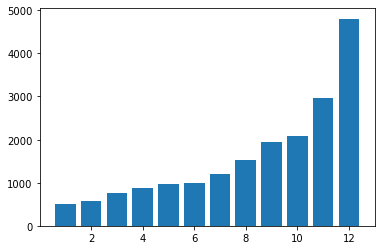

In [8]:
drug_approvals = pd.read_csv("../data/final_data/clean_approval_data.csv")
print("Approvals has {0} rows and {1} unique nda".format(drug_approvals.shape[0],drug_approvals.ID.nunique()))
plt.bar(np.arange(1, 13), np.bincount(drug_approvals.month, minlength=13)[1:])

## FDA Adverse Effect Data
### Dataset Description
FDA Adverse Event Reporting System (FAERS) gathers data from consumers related to any adverse effects that are encountered when the drugs are consumed. This data is cataloged at a drug level every quarter. Each row contains a unique NDA ID for the drug and the number of adverse events recorded during that quarter.

### Data source
FDA Adverse Effect dataset is a publicly available dataset which can be downloaded from https://fis.fda.gov/extensions/FPD-QDE-FAERS/FPD-QDE-FAERS.html

### Data Description
The data contains information from the year 2012 to 2021 with a total of 164,553 rows. Total number of unique drugs in this data is 10,362. The lowest number of adverse effects is 1 and the maximum is 347993.000000

In [9]:
faers = pd.read_csv("../data/final_data/FAERS_Summary_NDA.csv")
print(f"Number of rows is {faers.shape[0]}")
print(f"Number of unique drugs {len(pd.unique(faers['nda']))}")
faers.describe()

Number of rows is 164553
Number of unique drugs 10362


,year,quarter,adverse_affects
count,164553.000000,164553.000000,164553.000000
mean,2016.656007,2.560367,246.634325
std,2.510222,1.143563,2271.484457
min,2012.000000,1.000000,1.000000
25%,2015.000000,1.000000,3.000000
50%,2017.000000,3.000000,12.000000
75%,2019.000000,4.000000,75.000000
max,2021.000000,4.000000,347993.000000


## Drug Utlization Data
### Dataset Description
Drug utilization data are reported by states for covered outpatient drugs that are paid for by state Medicaid agencies since the start of the Medicaid Drug Rebate Program. The data includes state, drug name, National Drug Code, number of prescriptions and dollars reimbursed.

### Data source
Statewise drug utilization data is publicly available to download at https://www.medicaid.gov/medicaid/prescription-drugs/state-drug-utilization-data/index.html

### Data Description
The dataset contains 9.1 million rows with 29,638 unique drugs. The dataset does not contain the NDA ID available in the other datasets directly but we can join this dataset with another ndc to nda dataset to get the NDAs based on the ndc. After doing this we have 6.2 million rows with 9,196 unqiue drugs

In [10]:
def add_nda(utils_path,ndc_path):
    ndc = pd.read_csv(ndc_path)
    util = pd.read_csv(utils_path)
    print("Before")
    print("Number of rows in utlization is {0} with {1} unique drug names".format(util.shape[0],util.product_name.nunique()))
    ndc[['labeler_code','product_code']] = ndc['PRODUCTNDC'].str.split('-', 1, expand=True)
    ndc['labeler_code'] = [int(x) for x in ndc['labeler_code']]
    ndc['product_code'] = [int(x) for x in ndc['product_code']]
    #ndc = ndc[ndc.MARKETINGCATEGORYNAME == "NDA"]
    results = util.merge(ndc[['labeler_code','product_code','APPLICATIONNUMBER']],on=['labeler_code','product_code'],how='left')
    results = results.dropna(subset={"APPLICATIONNUMBER"})
    results = results.rename(columns={"APPLICATIONNUMBER":"NDA"})
    print("After")
    print("Number of rows in utlization is {0} with {1} unique nda".format(results.shape[0],results.NDA.nunique()))
    return results

In [11]:
utlization_path = "../data/drug_utlization_data/full_du.csv"
ndc_path = "../data/ndcxls/product.csv"
utilization_nda = add_nda(utlization_path,ndc_path)
utilization_nda.describe()

/Users/karunakargadireddy/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3338: DtypeWarning: Columns (3,8,18,19,20) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


Before
Number of rows in utlization is 9141916 with 29638 unique drug names
After
Number of rows in utlization is 6276922 with 9196 unique nda


,labeler_code,package_size,year,quarter,units_reimbursed,number_of_prescriptions,total_amount_reimbursed,medicaid_amount_reimbursed,non_medicaid_amount_reimbursed,latitude,longitude
count,6.276922e+06,6.276922e+06,6.276922e+06,6.276922e+06,4.001137e+06,4.001137e+06,4.001137e+06,4.001137e+06,4.001137e+06,5.976194e+06,5.976194e+06
mean,3.281028e+04,2.216422e+01,2.017137e+03,2.450969e+00,3.919714e+04,6.505536e+02,6.444700e+04,5.959206e+04,4.786070e+03,3.726564e+01,-9.452852e+01
std,2.877698e+04,2.714906e+01,3.788105e+00,1.196134e+00,1.026227e+06,5.903946e+03,9.821609e+05,9.551736e+05,1.322693e+05,8.164821e+00,3.226943e+01
min,2.000000e+00,0.000000e+00,1.991000e+03,1.000000e+00,1.600000e-02,1.100000e+01,0.000000e+00,0.000000e+00,0.000000e+00,1.424170e+01,-1.707197e+02
25%,4.090000e+02,2.000000e+00,2.015000e+03,1.000000e+00,9.300000e+02,3.300000e+01,5.623500e+02,5.132200e+02,0.000000e+00,3.381910e+01,-1.062371e+02
50%,4.257100e+04,1.000000e+01,2.018000e+03,2.000000e+00,3.257000e+03,8.900000e+01,2.197790e+03,2.029070e+03,0.000000e+00,3.851110e+01,-8.968120e+01
75%,6.233200e+04,3.100000e+01,2.020000e+03,4.000000e+00,1.313900e+04,3.040000e+02,1.011315e+04,9.312590e+03,7.004000e+01,4.223730e+01,-8.090660e+01
max,9.920700e+04,9.900000e+01,2.021000e+03,4.000000e+00,7.373561e+08,2.493449e+06,3.613896e+08,3.587193e+08,5.055292e+07,6.138500e+01,1.455505e+02


## Clinical Trail Data
### Data Description

### Data Source

### Data Description

In [12]:
clinical = pd.read_csv("../data/final_data/clinical_data_features.csv")
clinical = clinical.groupby(["drug name"])["EnrollmentCount","SumSeriousEventStatsNumAffected"].sum().reset_index()
clinical

<ipython-input-12-731a19c3091b>:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  clinical = clinical.groupby(["drug name"])["EnrollmentCount","SumSeriousEventStatsNumAffected"].sum().reset_index()


,drug name,EnrollmentCount,SumSeriousEventStatsNumAffected
0,ABELCET,114720.0,1680.0
1,ABILIFY,70839.0,1836.0
2,ABILIFY MAINTENA KIT,150.0,0.0
3,ABILIFY MYCITE KIT,150.0,0.0
4,ABRAXANE,2673.0,108.0
...,...,...,...
1775,ZYMAXID,2540.0,10.0
1776,ZYPREXA,25380.0,658.0
1777,ZYPREXA RELPREVV,4030.0,0.0
1778,ZYTIGA,174.0,111.0


## Open Paymenets Dataset
### Dataset description

### Data source

### Data description

In [25]:
import os
import warnings
from polyfuzz.models import TFIDF
from polyfuzz import PolyFuzz
warnings.simplefilter(action='ignore', category=FutureWarning)

directory = "../data/final_data/Research Payments/"
words_to_remove = ["INC","PHARMS","PHARMA", "PHARMACEUTICALS", "PHARMACEUTICAL","LLC","LABS","PHARM","LTD","THERAP","THERAPS","US","USA","CO","AND","INTL","HLTHCARE","CORP","SCIENCES","LP","HEALTHCARE","DR"]

def process_columns(df, columns):
    """Function for preprocessing string columns in pandas dataframe
    Args:
        df (pandas dataframe): pandas dataframe to be preprocessed
        columns (list): list of string columns to be preprocessed
    Returns:
        pandas dataframe: preprocessed dataframe
    """
    for column in columns:
        new_col_name = column + "_new"
        df[new_col_name] = df[column].str.upper().str.strip().str.replace('\W+', '')
        for w in words_to_remove:
            df[new_col_name] = df[new_col_name].str.replace(w, '',regex=True)
        df[new_col_name] = df[new_col_name].str.strip()
    
    return df

In [26]:
def match_column_name(util, payment, threshold):
    list_one = list(util["Company_new"].unique())
    list_two = list(payment["Submitting_Applicable_Manufacturer_or_Applicable_GPO_Name_new"].unique())

    model = PolyFuzz("TF-IDF")
    model.match(list_one, list_two)
    
    df_match = model.get_matches()
    df_match = df_match[df_match["Similarity"]>=threshold]
    
    return df_match

In [27]:
def merge_util_payments(util, payment, merge_df):
    df_step_one = util.merge(merge_df, how="left", left_on='Company_new', right_on='From')
    
    util_final = df_step_one.merge(payment, how="left", left_on=['To','year_y'], right_on=['Submitting_Applicable_Manufacturer_or_Applicable_GPO_Name_new','Year_of_Payment'])
    
    util_final['Payment_Sum'] = util_final['Payment_Sum'].replace(np.nan, 0)
    util_final['Payment_Count'] = util_final['Payment_Count'].replace(np.nan, 0)
    
    return util_final

In [28]:
def concat_payments_data(util, directory, threshold):
    fileList = os.listdir(directory)
    df_concat = pd.DataFrame()

    for file in fileList:
        filePath = os.path.join(directory, file)
        df = pd.read_csv(filePath, usecols=["Date_of_Payment", "Submitting_Applicable_Manufacturer_or_Applicable_GPO_Name", "Total_Amount_of_Payment_USDollars"])
        print(filePath, df.shape)
        
        df = process_columns(df, ["Submitting_Applicable_Manufacturer_or_Applicable_GPO_Name"])
        
        df['Date_of_Payment'] = pd.to_datetime(df['Date_of_Payment'])
        df['Year_of_Payment'] = df['Date_of_Payment'].dt.year
        
        df_grouped = df.groupby(by=["Submitting_Applicable_Manufacturer_or_Applicable_GPO_Name_new", "Year_of_Payment"])["Total_Amount_of_Payment_USDollars"].agg(Payment_Sum='sum', Payment_Count='count').reset_index()
        
        year = df_grouped["Year_of_Payment"].unique()[0]
        util_year_subset = util[util["year_y"]==year]
        df_match = match_column_name(util_year_subset, df_grouped, threshold)
        util_final = merge_util_payments(util_year_subset, df_grouped, df_match)
        
        df_concat = pd.concat([df_concat, util_final])
        print(df_concat.shape)
    
    return df_concat

# Merging Datasets
## Merge FDA Approvals and FDA Adverse Events Data

Both the FDA Approvals and FDA Adverse Events data both have NDA. We perform an inner join of both faers dataset and drug approvals dataset on the NDA column. After the join we have 160,279 rows and 8,894 unique drugs.

In [18]:
faers['year']=faers.year.astype('int64')
faers['quarter']=faers.quarter.astype('int64')
drug_approvals = drug_approvals.rename(columns={"ID":"NDA"})
faers = faers.rename(columns={"nda":"NDA"})
fares_plus_approval = faers.merge(drug_approvals,on= ["NDA"],how='right')
print("After merging fares and approval")
print("Number of rows is {0} and number of unique nda is {1}".format(fares_plus_approval.shape[0],fares_plus_approval.NDA.nunique()))
fares_plus_approval.head(2)

After merging fares and approval
Number of rows is 170043 and number of unique nda is 18341


,NDA,year_x,quarter,adverse_affects,Approval Date,Drug Name,Submission,Active Ingredients,Company,Submission Classification *,Submission Status,year_y,month
0,NDA018746,NaN,NaN,NaN,01/02/2001,VASOCON-ANDA #018746,SUPPL-11,ANTAZOLINE PHOSPHATE; NAPHAZOLINE HYDROCHLORIDE,NOVARTIS,Manufacturing (CMC),Approval,2001,1
1,NDA088367,NaN,NaN,NaN,01/02/2002,LIDOCAINE HYDROCHLORIDE IN PLASTIC CONTAINERAN...,SUPPL-11,LIDOCAINE HYDROCHLORIDE,HOSPIRA,Labeling,Approval,2002,1


## Merging with Drug Utilization Data

In [19]:
import regex as re
def clean_drug_name(df):
    try:
        drug_id = df['Drug Name'].split("#",1)[1]
        nda_split = df['Drug Name'].split("NDA",1)[0]
        if(' ' not in nda_split):
                drug_name = nda_split
                dosage = "None"
        elif('PLASTIC' in nda_split): 
                dosage = nda_split.split(' ',1)[1]
                drug_name = nda_split.split(' ',1)[0]
        else:
                drug_name = (re.split(r'(^[^\d]+)', nda_split)[1:])[0]
                dosage = (re.split(r'(^[^\d]+)', nda_split)[1:])[1]


        return(drug_name,dosage,drug_id)
    except:
        return

In [20]:
#Merge utilization and approval dates and fares
utilization_nda['year']=utilization_nda.year.astype('int64')
utilization_nda['quarter']=utilization_nda.quarter.astype('int64')
utilization_nda['NDA'] = utilization_nda['NDA'].str.replace('ANDA', 'NDA')
utilization_nda['NDA'] = utilization_nda['NDA'].str.replace('BLA', 'NDA')
faers['year']=faers.year.astype('int64')
faers['quarter']=faers.quarter.astype('int64')
utilization_plus_approval = utilization_nda.merge(drug_approvals,on= ["NDA"],how='inner')
utilization_plus_approval = utilization_plus_approval.rename(columns={"year_x":"year"})
utilization_approval_fares = utilization_plus_approval.merge(faers,on=["NDA","year","quarter"],how="inner")
#utilization_approval_fares.adverse_affects.fillna(0)
utilization_approval_fares[['Drug Name', 'dosage', 'drug_id']] = utilization_approval_fares.apply(clean_drug_name, axis=1, result_type="expand")

print("After merging fares, utlization and approvals")
print("Number of rows is {0} and number of unique nda is {1}".format(utilization_approval_fares.shape[0],utilization_approval_fares.NDA.nunique()))


After merging fares, utlization and approvals
Number of rows is 3544366 and number of unique nda is 5467


## Merging the above data with clinical trail data

In [21]:
clinical = clinical.rename(columns={"drug name":"Drug Name"})
clinical = clinical.groupby("Drug Name").sum().reset_index()
utilization_approval_fares_clinical = utilization_approval_fares.merge(clinical,on=["Drug Name"],how="inner")
print("After merging fares,utilization, approvals and clinical data")
print("Number of rows is {0} and number of unique nda is {1}".format(utilization_approval_fares_clinical.shape[0],utilization_approval_fares_clinical.NDA.nunique()))

After merging fares,utilization, approvals and clinical data
Number of rows is 1489216 and number of unique nda is 2015


## Merging the above data with open payments data

In [31]:
utilization_approval_fares_clinical = process_columns(utilization_approval_fares_clinical, ["Company"])
utilization_approval_fares_clinical_payments =  concat_payments_data(utilization_approval_fares_clinical, directory, 0.5)
years_to_concat = [2002, 2008, 2013, 2001, 2005, 2006, 2011, 2003, 2012, 2007, 2021, 2009, 2010, 2004]
for y in years_to_concat:
    util_year_subset = utilization_approval_fares_clinical[utilization_approval_fares_clinical["year_y"]==y]
    utilization_approval_fares_clinical_payments = pd.concat([utilization_approval_fares_clinical_payments, util_year_subset])
print("After merging fares, utlization and approvals")
print("Number of rows is {0} and number of unique nda is {1}".format(utilization_approval_fares_clinical_payments.shape[0],utilization_approval_fares_clinical_payments.NDA.nunique()))


../data/final_data/Research Payments/OP_DTL_RSRCH_PGYR2014_P06302021.csv (793342, 3)
(108542, 44)
../data/final_data/Research Payments/OP_DTL_RSRCH_PGYR2017_P06302021.csv (720844, 3)
(176834, 44)
../data/final_data/Research Payments/OP_DTL_RSRCH_PGYR2020_P06302021.csv (589362, 3)
(214070, 44)
../data/final_data/Research Payments/OP_DTL_RSRCH_PGYR2019_P06302021.csv (682535, 3)
(274026, 44)
../data/final_data/Research Payments/OP_DTL_RSRCH_PGYR2018_P06302021.csv (664614, 3)
(337892, 44)
../data/final_data/Research Payments/OP_DTL_RSRCH_PGYR2016_P06302021.csv (879422, 3)
(457226, 44)
../data/final_data/Research Payments/OP_DTL_RSRCH_PGYR2015_P06302021.csv (956956, 3)
(600900, 44)
After merging fares, utlization and approvals
Number of rows is 1489216 and number of unique nda is 2015


In [32]:
utilization_approval_fares_clinical_payments.head(2).T

,0,1
utilization_type,MCOU,MCOU
state,NJ,VA
labeler_code,75987.0,75987.0
product_code,40,40
package_size,5.0,5.0
year,2017,2017
quarter,4,4
product_name,Pennsaid,PENNSAID
suppression_used,False,False
units_reimbursed,50.0,36.0


### Data Filtering

We filter the columns that we need from the combined dataset. We also remove the adverse effects for a drug that are reported before the corresponding FDA Drug Approval date. We also remove the rows that have more adverse effects than the number of units that were reimbursed in that quarter. The active ingredients are split into a array using ',' as token.

In [60]:
df = utilization_approval_fares_clinical_payments
df_subset = df[['utilization_type', 'state',
       'package_size', 'year', 'quarter', 'suppression_used',
       'units_reimbursed', 'Submission', 'Active Ingredients',
       'Company', 'Submission Classification *', 'year_y',
       'month', 'adverse_affects', 'NDA',"EnrollmentCount","SumSeriousEventStatsNumAffected","Payment_Sum","Payment_Count"]]
df_subset.columns = ['utilization_type', 'state',
       'package_size', 'year', 'quarter', 'suppression_used',
       'units_reimbursed', 'submission', 'active_ingredients',
       'company', 'submission_classification', 'approval_year',
       'approval_month', 'adverse_affects', 'NDA',"clinical_enrollment","clinical_adverse_events","total_payment","payment_count"]
df_subset = df_subset[df_subset['units_reimbursed'] >= df_subset['adverse_affects']]
df_subset['approval_quarter'] = df_subset['approval_month']//4 + 1
df_subset = df_subset.dropna(subset=['approval_year', 'approval_month', 'approval_quarter'])
df_subset['time_since_approval'] = df_subset['year'] - df_subset['approval_year']
df_subset = df_subset[df_subset['time_since_approval'] >= 0]
df_subset['rate'] = df_subset['adverse_affects']/df_subset['units_reimbursed']
df_subset["active_ingredients"] = df_subset.active_ingredients.apply(lambda x:tuple(set(x.split(","))))
df_subset

,utilization_type,state,package_size,year,quarter,suppression_used,units_reimbursed,submission,active_ingredients,company,...,approval_month,adverse_affects,NDA,clinical_enrollment,clinical_adverse_events,total_payment,payment_count,approval_quarter,time_since_approval,rate
3,MCOU,NY,5.0,2017,4,False,713.893,SUPPL-3,"(DICLOFENAC SODIUM,)",HORIZON,...,11,56,NDA204623,6396.0,384.0,209120.39,156.0,3,3,0.078443
8,MCOU,NY,5.0,2017,4,False,713.893,SUPPL-3,"(DICLOFENAC SODIUM,)",HORIZON,...,11,56,NDA204623,6396.0,384.0,209120.39,156.0,3,3,0.078443
10,MCOU,TX,5.0,2017,3,False,264.000,SUPPL-3,"(DICLOFENAC SODIUM,)",HORIZON,...,11,69,NDA204623,6396.0,384.0,209120.39,156.0,3,3,0.261364
12,FFSU,CO,5.0,2017,3,False,73.339,SUPPL-3,"(DICLOFENAC SODIUM,)",HORIZON,...,11,69,NDA204623,6396.0,384.0,209120.39,156.0,3,3,0.940836
14,FFSU,NY,5.0,2017,3,False,112.000,SUPPL-3,"(DICLOFENAC SODIUM,)",HORIZON,...,11,69,NDA204623,6396.0,384.0,209120.39,156.0,3,3,0.616071
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1478842,MCOU,IL,1.0,2020,4,NaN,7350.000,SUPPL-6,"(NAPROXEN,)",ATNAHS PHARMA US,...,11,5,NDA020067,197258.0,9308.0,NaN,NaN,3,16,0.000680
1478844,FFSU,AK,1.0,2020,4,NaN,560.000,SUPPL-6,"(NAPROXEN,)",ATNAHS PHARMA US,...,11,5,NDA020067,197258.0,9308.0,NaN,NaN,3,16,0.008929
1478847,MCOU,GA,1.0,2020,4,NaN,2170.000,SUPPL-6,"(NAPROXEN,)",ATNAHS PHARMA US,...,11,5,NDA020067,197258.0,9308.0,NaN,NaN,3,16,0.002304
1478849,MCOU,IA,1.0,2020,4,NaN,1886.000,SUPPL-6,"(NAPROXEN,)",ATNAHS PHARMA US,...,11,5,NDA020067,197258.0,9308.0,NaN,NaN,3,16,0.002651


The active ingredients and company are label encoded. The time since approval for all the quarters is set as the time since approval of the first quarter to group the data later.

In [61]:
#unique_ingredients = df_subset["active_ingredients"].explode().unique().tolist()
#max_ingredients = df_subset["active_ingredients"].apply(len).max()
#ingredient_labels = {c:i+1 for i,c in enumerate(unique_ingredients)}
#ingredient_labels[""] = 0
#df_subset["active_ingredients"] = df_subset.active_ingredients.apply(lambda x: tuple([ingredient_labels[i] for i in x]+[0 for _ in range(max_ingredients-len(x))]))
grouped = df_subset.groupby("NDA").max().reset_index()
time_since = dict(zip(grouped.NDA, grouped.time_since_approval))
approval_month_dict = dict(zip(grouped.NDA, grouped.approval_month))
company_dict = dict(zip(grouped.company, range(grouped.company.shape[0])))
#df_subset["company"] = df_subset.company.apply(lambda x:company_dict[x])
df_subset["time_since_approval"] = df_subset.NDA.apply(lambda x:time_since[x])
df_subset["approval_month"] = df_subset.NDA.apply(lambda x:approval_month_dict[x])

The data is grouped by "NDA",'utilization_type', 'package_size','suppression_used', 'company',"approval_month", 'time_since_approval',"active_ingredients". We believe that a change in the value of any of these columns should be considered as a new data point.

In [62]:
model_parameters = ["NDA",'utilization_type', 'package_size',
       'suppression_used', 'approval_month',
       'active_ingredients', 'company', 'time_since_approval', "adverse_affects",'units_reimbursed',"clinical_enrollment","clinical_adverse_events","total_payment","payment_count"]
df_model= df_subset[model_parameters]
df_model = df_model.groupby(["NDA",'utilization_type', 'package_size','suppression_used', 'company',"approval_month", 'time_since_approval',"active_ingredients"]).sum()
df_model['rate'] = df_model['adverse_affects']/df_model['units_reimbursed']
df_model['avg_payment'] = df_model['total_payment']/(df_model['payment_count']+1)
df_model =df_model.reset_index()
df_model['clinical_rate'] = (df_model["clinical_adverse_events"])/(df_model["clinical_enrollment"]+1)

In [95]:
df_model

,NDA,company,approval_month,time_since_approval,active_ingredients,adverse_affects,units_reimbursed,clinical_enrollment,clinical_adverse_events,total_payment,...,ALKEM,LYNE,TOLMAR,HILL DERMAC,NOVEL LABS INC,BRAINTREE,B BRAUN,ACTAVIS MID ATLANTIC,PARAPRO LLC,LEADING PHARMA LLC
0,NDA004782,WYETH PHARMS,12,19,"( CONJUGATED, ESTROGENS)",399846,4027298.00,17550000.0,175500.0,0.000000e+00,...,0,0,0,0,0,0,0,0,0,0
1,NDA004782,WYETH PHARMS,12,19,"( CONJUGATED, ESTROGENS)",22672,53128.00,1053000.0,10530.0,0.000000e+00,...,0,0,0,0,0,0,0,0,0,0
2,NDA004782,WYETH PHARMS,12,19,"( CONJUGATED, ESTROGENS)",1000832,12956435.64,42751800.0,427518.0,0.000000e+00,...,0,0,0,0,0,0,0,0,0,0
3,NDA004782,WYETH PHARMS,12,19,"( CONJUGATED, ESTROGENS)",90586,276458.00,4001400.0,40014.0,0.000000e+00,...,0,0,0,0,0,0,0,0,0,0
4,NDA005378,RECORDATI RARE,12,17,"(METHAMPHETAMINE HYDROCHLORIDE,)",34,13754.00,200880.0,1488.0,0.000000e+00,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6322,NDA213973,DECIPHERA PHARMS,6,0,"(RIPRETINIB,)",902,6660.00,248.0,0.0,0.000000e+00,...,0,0,0,0,0,0,0,0,0,0
6323,NDA214094,BIOCRYST,12,1,"(BEROTRALSTAT HYDROCHLORIDE,)",22,1120.00,220.0,0.0,4.665501e+06,...,0,0,0,0,0,0,0,0,0,0
6324,NDA214120,CELGENE CORP,9,1,"(AZACITIDINE,)",42,616.00,8478.0,2808.0,1.517949e+08,...,0,0,0,0,0,0,0,0,0,0
6325,NDA214120,CELGENE CORP,9,1,"(AZACITIDINE,)",42,1008.00,8478.0,2808.0,1.517949e+08,...,0,0,0,0,0,0,0,0,0,0


In [63]:
ac_rates = {}
company_rates = {}
for _,r in df_model.iterrows():
    acs = r["active_ingredients"]
    util = r["units_reimbursed"]
    adv = r["adverse_affects"]
    company = r["company"]
    company_rates.setdefault(company,[0,0])
    company_rates[company][0]+=util
    company_rates[company][1]+=adv
    for ac in acs:
        ac_rates.setdefault(ac,[0,0])
        ac_rates[ac][0]+=util
        ac_rates[ac][1]+=adv
for ac,(u,a) in ac_rates.items():
    ac_rates[ac] = a/u
for c,(u,a) in company_rates.items():
    company_rates[c] = a/u
    
top_ac = [x for x,y in sorted(ac_rates.items(),reverse=True,key=lambda p:p[1])]
top_ac_array = []
for _,r in df_model.iterrows():
    acs = r["active_ingredients"]
    row_array = []
    for ac in top_ac:
        if ac in acs:
            row_array.append(1)
        else:
            row_array.append(0)
    top_ac_array.append(row_array)
active_ingredients = pd.DataFrame(np.array(top_ac_array),columns = top_ac)


    
top_company = [x for x,y in sorted(company_rates.items(),reverse=True,key=lambda p:p[1])]
top_company_array = []
for _,r in df_model.iterrows():
    company = r["company"]
    row_array = []
    for c in top_company:
        if c==company:
            row_array.append(1)
        else:
            row_array.append(0)
    top_company_array.append(row_array)
active_ingredients = pd.DataFrame(np.array(top_ac_array),columns = top_ac)
companies = pd.DataFrame(np.array(top_company_array),columns = top_company)

In [64]:
categorical_cols = ['utilization_type', 'package_size', 'suppression_used']
df_model = pd.get_dummies(df_model,columns=categorical_cols)
#active_ingredients= pd.DataFrame(df_model.active_ingredients.values.tolist()).add_prefix('ai_')
#one_hot_active = pd.get_dummies(active_ingredients,columns =active_ingredients.columns)
df_model = pd.concat([df_model, active_ingredients], axis=1)
df_model = pd.concat([df_model, companies], axis=1)


In [118]:
from sklearn.model_selection import train_test_split
covariates = list(set(df_model.columns) - set(["total_payment","payment_count","clinical_enrollment","clinical_adverse_events","rate","NDA","active_ingredients","adverse_affects","units_reimbursed","company"]))
X = df_model[covariates]
y = np.log(df_model["rate"])
#y = (y-y.mean())/(y.std())
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)


In [119]:
import statsmodels.api as sm
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
model = sm.OLS(y_train.values.reshape(-1,1),X_train)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.784
Model:                            OLS   Adj. R-squared:                  0.700
Method:                 Least Squares   F-statistic:                     9.376
Date:                Sat, 27 Nov 2021   Prob (F-statistic):               0.00
Time:                        17:26:36   Log-Likelihood:                -8152.0
No. Observations:                5061   AIC:                         1.913e+04
Df Residuals:                    3648   BIC:                         2.836e+04
Df Model:                        1412                                         
Covariance Type:            nonrobust                                         
=============================================================================================================================================================================================================================================================================================================
                                                                                                                                                                                                                                                coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
PRAZIQUANTEL                                                                                                                                                                                                                                 -0.3854      1.271     -0.303      0.762      -2.878       2.107
GENENTECH INC                                                                                                                                                                                                                                 0.6108      0.458      1.332      0.183      -0.288       1.509
MERCK AND CO INC                                                                                                                                                                                                                             -2.3682      2.436     -0.972      0.331      -7.145       2.409
SUMATRIPTAN SUCCINATE                                                                                                                                                                                                                         1.0183      0.692      1.472      0.141      -0.338       2.375
DROSPIRENONE                                                                                                                                                                                                                                 -0.9008      0.511     -1.764      0.078      -1.902       0.100
LATANOPROST                                                                                                                                                                                                                                   0.4661      1.057      0.441      0.659      -1.607       2.539
UNICHEM                                                                                                                                                                                                                                       1.5136      0.841      1.800      0.072      -0.135       3.162
DULOXETINE HYDROCHLORIDE                                       

In [120]:
predictions = results.predict(X_test)
mse = mean_squared_error(y_test, predictions)
r2 = r2_score(y_test,predictions)
print(f"Test MSE IS {mse:0.2f} R^2 is {r2:0.2f}")
predictions = results.predict(X_train)
mse = mean_squared_error(y_train, predictions)
r2 = r2_score(y_train,predictions)
print(f"Train MSE IS {mse:0.2f} R^2 is {r2:0.2f}")

Test MSE IS 2.68 R^2 is 0.61
Train MSE IS 1.47 R^2 is 0.78


### Random Forest Regression

In [121]:
regr = RandomForestRegressor(n_jobs=-1,random_state=10)
regr.fit(X_train, y_train)
y_pred = regr.predict(X_test)
y_true = y_test
mse = mean_squared_error(y_true, y_pred)
r2 = r2_score(y_true,y_pred)
print(f"Test MSE IS {mse:0.2f} R^2 is {r2:0.2f}")
predictions = regr.predict(X_train)
mse = mean_squared_error(y_train, predictions)
r2 = r2_score(y_train,predictions)
print(f"Train MSE IS {mse:0.2f} R^2 is {r2:0.2f}")

Test MSE IS 1.63 R^2 is 0.76
Train MSE IS 0.25 R^2 is 0.96


### Ridge Regression

In [122]:
from sklearn.linear_model import Ridge

In [123]:
regr = Ridge(alpha=.5).fit(X_train, y_train)
y_pred = regr.predict(X_test)
y_true = y_test
mse = mean_squared_error(y_true, y_pred)
r2 = r2_score(y_true,y_pred)
print(f"MSE IS {mse:0.2f} R^2 is {r2:0.2f}")
predictions = regr.predict(X_train)
mse = mean_squared_error(y_train, predictions)
r2 = r2_score(y_train,predictions)
print(f"Train MSE IS {mse:0.2f} R^2 is {r2:0.2f}")

MSE IS 2.40 R^2 is 0.65
Train MSE IS 1.56 R^2 is 0.77


### Voting Regression

In [126]:
from sklearn.ensemble import VotingRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge

In [ ]:
reg1 = GradientBoostingRegressor(random_state=1)
reg2 = RandomForestRegressor(n_jobs=-1,random_state=1)
reg3 = Ridge(alpha = 0.1)
ereg = VotingRegressor(estimators=[('gb', reg1), ('rf', reg2), ('rr', reg3)])
ereg = ereg.fit(X_train, y_train)
y_pred = ereg.predict(X_test)
y_true = y_test
mse = mean_squared_error(y_true, y_pred)
r2 = r2_score(y_true,y_pred)
print(f"MSE IS {mse:0.2f} R^2 is {r2:0.2f}")
predictions = ereg.predict(X_train)
mse = mean_squared_error(y_train, predictions)
r2 = r2_score(y_train,predictions)
print(f"Train MSE IS {mse:0.2f} R^2 is {r2:0.2f}")